## Connection to Drive Established

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [9]:
from pathlib import Path
image_dir = Path("/content/drive/MyDrive/pics")

In [13]:
test_images = []
for ext in ["*.jpg", "*.png", "*.jpeg", "*.JPG", "*.PNG", "*.JPEG"]:
    test_images.extend(image_dir.glob(ext))

test_images

[PosixPath('/content/drive/MyDrive/pics/IMG_5151.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5153.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5154.JPG'),
 PosixPath('/content/drive/MyDrive/pics/IMG_5152.PNG')]

#### PHASE 1: PyTesseract OCR





PyTesseract and the underlying Tesseract OCR engine were installed in the Colab environment. PyTesseract acts as a Python interface to the Tesseract OCR engine.

In [14]:
!pip install pytesseract
!apt-get install -y tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [15]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import numpy as np

The original test images were visualized to inspect their quality, clarity, and presence of printed or handwritten text.

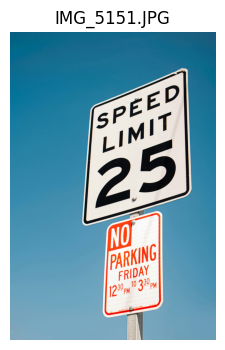

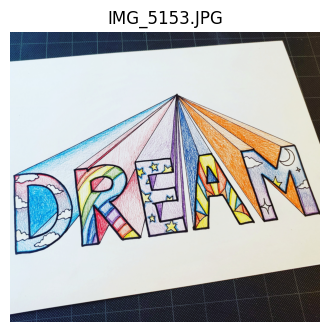

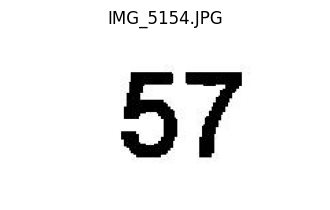

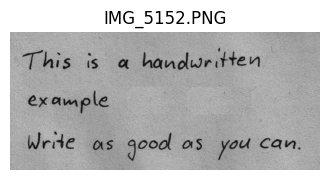

In [16]:
for img_path in test_images:
    img = cv2.imread(str(img_path))
    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_path.name)
    plt.axis("off")

Images were converted to grayscale to reduce color complexity and upscaled to enhance character visibility. This minimal preprocessing helps improve PyTesseract’s OCR performance.

In [17]:
def preprocess_for_tesseract(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    return gray

PyTesseract was applied to the preprocessed images to extract raw textual content. This provides a baseline OCR output without detailed localization or confidence information.

In [26]:
for img_path in test_images:
    img = cv2.imread(str(img_path))
    gray = preprocess_for_tesseract(img)
    text = pytesseract.image_to_string(gray)

    print("="*50)
    print(img_path.name)
    print("="*50)
    print(text)

IMG_5151.JPG
 

IMG_5153.JPG
sey

\

we

aS
ve

Sa

 

IMG_5154.JPG
of

IMG_5152.PNG
This is a handwritten
example

Write as qooal as you can.



***As visible, the returned text is either missing or wrong.***

To obtain detailed OCR information, PyTesseract’s image_to_data() function was used. This returns structured word-level data including bounding boxes, confidence scores, and layout hierarchy.

In [19]:
from pytesseract import Output

img = cv2.imread(str(test_images[0]))
gray = preprocess_for_tesseract(img)

data = pytesseract.image_to_data(gray, output_type=Output.DICT)
data.keys()

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

Word-level confidence scores were examined for detected text. Printed text generally yielded higher confidence values, while handwritten text often resulted in missing or low-confidence detections.


In [21]:
for i in range(len(data['text'])):
    word = data['text'][i]
    conf = data['conf'][i]
    if word.strip():
        print(f"{word:15s} | Confidence: {conf}")

***As we can see, nothing gets printed, so PyTesseract failed to confidently detect words.***

Bounding boxes were drawn around detected words with positive confidence scores.


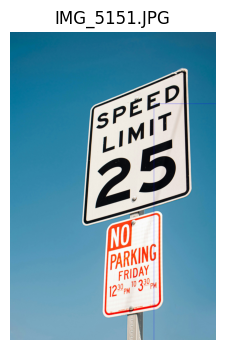

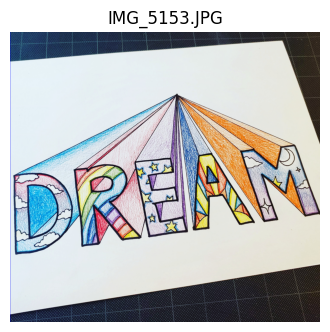

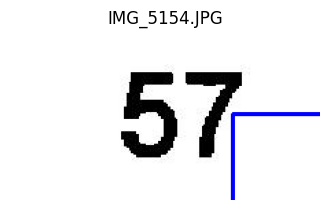

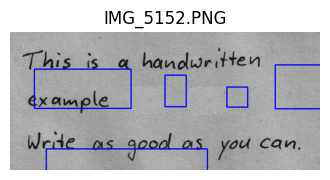

In [22]:
for img_path in test_images:
    img = cv2.imread(str(img_path))
    gray = preprocess_for_tesseract(img)
    data = pytesseract.image_to_data(gray, output_type=Output.DICT)

    img_box = img.copy()
    for i in range(len(data['text'])):
        if int(data['conf'][i]) > 0:
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            cv2.rectangle(img_box, (x,y), (x+w,y+h), (255,0,0), 2)

    plt.figure(figsize=(4,4))
    plt.imshow(cv2.cvtColor(img_box, cv2.COLOR_BGR2RGB))
    plt.title(img_path.name)
    plt.axis("off")

***The visualization revealed fragmented or misplaced boxes for handwritten text, indicating limitations of PyTesseract’s heuristic-based segmentation.***